# Fake News classifier 

### code derived from this Kaggle notebook: 
https://www.kaggle.com/code/dhirajchandak04/news-classification-for-beginner

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import string
import nltk

In [2]:
fake = pd.read_csv("data/Fake.csv")
real = pd.read_csv("data/True.csv")
print("Fake Shape: {} \nReal Shape: {}".format(fake.shape, real.shape))

Fake Shape: (23481, 4) 
Real Shape: (21417, 4)


In [3]:
real['subject'].unique()

array(['politicsNews', 'worldnews'], dtype=object)

In [4]:
fake['subject'].unique()

array(['News', 'politics', 'Government News', 'left-news', 'US_News',
       'Middle-east'], dtype=object)

In [5]:
fake['category'] = 'fake'
real['category'] = 'real'
print("Fake Shape: {} \nReal Shape: {}".format(fake.shape, real.shape))

Fake Shape: (23481, 5) 
Real Shape: (21417, 5)


### Whether headlines of news are sufficient enough to classify it correctly?

In [6]:
df = fake.append(real)
df.shape

(44898, 5)

/Users/CaitlanKrasinski/miniconda3/envs/av/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='category'>

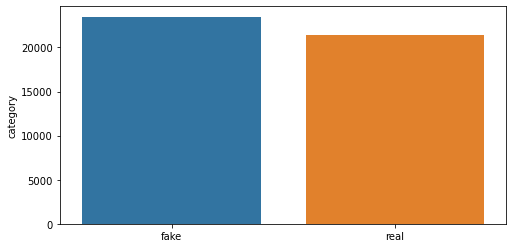

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,4))
sns.barplot(df['category'].value_counts().index, df['category'].value_counts())

## Encoding category variable

In [8]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
df['category']=le.fit_transform(df['category'])
df.head()

,title,text,subject,date,category
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


## Train, Validation and Test dataset.

Will train the model on training dataset and test the accuracy on validation dataset. Once we finalize the model, we will test it on testing dataset to know the performance and accuracy of the model on unseen dataset.

In [9]:
X = df.drop(['text','subject','date','category'], axis=1)
y = df['category']
print("X shape: {}".format(X.shape))
print("y shape: {}".format(y.shape))

X shape: (44898, 1)
y shape: (44898,)


In [10]:
from sklearn.model_selection import train_test_split
X_train, test_X, y_train, test_y = train_test_split(X,y,test_size=0.2,random_state=45,stratify=y)

train_X, val_X, train_y, val_y = train_test_split(X_train,y_train,test_size=0.25,random_state=42,stratify=y_train)

print("train_X shape: {}".format(train_X.shape))
print("train_y shape: {}".format(train_y.shape))
print("val_X shape: {}".format(val_X.shape))
print("val_y shape: {}".format(val_y.shape))
print("test_X shape: {}".format(test_X.shape))
print("test_y shape: {}".format(test_y.shape))

train_X shape: (26938, 1)
train_y shape: (26938,)
val_X shape: (8980, 1)
val_y shape: (8980,)
test_X shape: (8980, 1)
test_y shape: (8980,)


## Text Preprocessing

In [11]:
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))

def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stopwords])

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join(lemmatizer.lemmatize(word) for word in text.split())

def preprocessing(df, col):
    df['lower'] = df[col].str.lower()
    df['wo_punc'] = df['lower'].apply(lambda text: re.sub('[^a-zA-Z0-9]', ' ', text))
    df['wo_stopw'] = df['wo_punc'].apply(lambda text: remove_stopwords(text))
    df["lemmatized"] = df["wo_stopw"].apply(lambda text: lemmatize_words(text))
    df.drop([col, 'lower', 'wo_stopw', 'wo_punc'], axis=1, inplace=True)
    return df

In [12]:
train_X = preprocessing(train_X, 'title')
val_X = preprocessing(val_X, 'title')
test_X = preprocessing(test_X, 'title')
print("Train Shape: {} \nValidation Shape: {} \nTest Shape: {}".format(train_X.shape, val_X.shape, test_X.shape))

<ipython-input-11-0c86b8859847>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lower'] = df[col].str.lower()
<ipython-input-11-0c86b8859847>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wo_punc'] = df['lower'].apply(lambda text: re.sub('[^a-zA-Z0-9]', ' ', text))
<ipython-input-11-0c86b8859847>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

Train Shape: (26938, 1) 
Validation Shape: (8980, 1) 
Test Shape: (8980, 1)


## Matrix Generation using Bag of Word

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
bow = CountVectorizer(max_features=9000)
train_vector_bow = bow.fit_transform(train_X['lemmatized']).toarray()
val_vector_bow = bow.transform(val_X['lemmatized']).toarray()
test_vector_bow = bow.transform(test_X['lemmatized']).toarray()

## Model

In [14]:
from sklearn.linear_model import LogisticRegression

lrc_bow = LogisticRegression().fit(train_vector_bow,train_y)

### Fine tune the model on **Validation dataset**.

<AxesSubplot:>

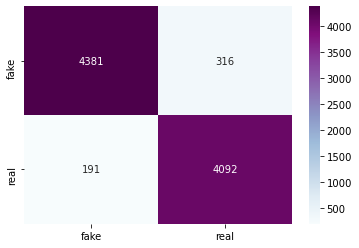

In [15]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

val_pred_lrc_bow = lrc_bow.predict(val_vector_bow)
cm=confusion_matrix(val_y,val_pred_lrc_bow)
sns.heatmap(cm,cmap='BuPu',annot=True,fmt='d', xticklabels=['fake', 'real'], yticklabels=['fake', 'real'])

## Predict and find out the accuracy on test dataset (Matrix generated using BoW)

<AxesSubplot:>

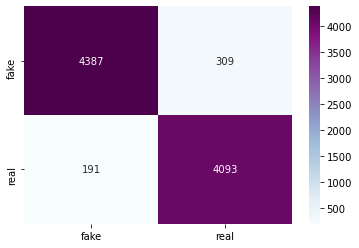

In [16]:
test_pred_lrc_bow = lrc_bow.predict(test_vector_bow)
cm = confusion_matrix(test_y,test_pred_lrc_bow)
sns.heatmap(cm,cmap='BuPu',annot=True,fmt='d', xticklabels=['fake', 'real'], yticklabels=['fake', 'real'])

In [17]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

print('******** Logistic Regression **********')
print('Precision Score: ',precision_score(test_y,test_pred_lrc_bow))
print('Recall Score: ',recall_score(test_y,test_pred_lrc_bow))
print('Accuracy Score: ',accuracy_score(test_y,test_pred_lrc_bow))
print('********************************************')

******** Logistic Regression **********
Precision Score:  0.9298046342571559
Recall Score:  0.9554154995331466
Accuracy Score:  0.9443207126948775
********************************************


## Matrix Generation using TF-IDF

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=9000)
train_vector_tfidf = tfidf.fit_transform(train_X['lemmatized']).toarray()
val_vector_tfidf = tfidf.transform(val_X['lemmatized']).toarray()
test_vector_tfidf = tfidf.transform(test_X['lemmatized']).toarray()

In [19]:
from sklearn.linear_model import LogisticRegression

lrc_tfidf = LogisticRegression().fit(train_vector_tfidf,train_y)

### Fine tune the model on **Validation dataset**.

<AxesSubplot:>

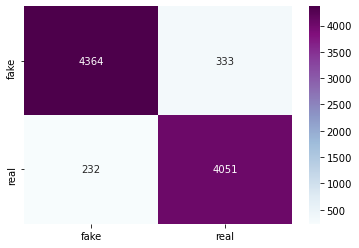

In [20]:
val_pred_lrc_tfidf = lrc_tfidf.predict(val_vector_tfidf)
cm=confusion_matrix(val_y,val_pred_lrc_tfidf)
sns.heatmap(cm,cmap='BuPu',annot=True,fmt='d', xticklabels=['fake', 'real'], yticklabels=['fake', 'real'])

## Predict and find out the accuracy on test dataset (Matrix generated using TF-IDF)

<AxesSubplot:>

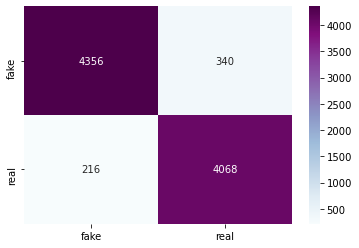

In [21]:
test_pred_lrc_tfidf = lrc_tfidf.predict(test_vector_tfidf)
cm = confusion_matrix(test_y,test_pred_lrc_tfidf)
sns.heatmap(cm,cmap='BuPu',annot=True,fmt='d', xticklabels=['fake', 'real'], yticklabels=['fake', 'real'])

In [22]:
print('******** Logistic Regression **********')
print('Precision Score: ',precision_score(test_y,test_pred_lrc_tfidf))
print('Recall Score: ',recall_score(test_y,test_pred_lrc_tfidf))
print('Accuracy Score: ',accuracy_score(test_y,test_pred_lrc_tfidf))
print('********************************************')

******** Logistic Regression **********
Precision Score:  0.9228675136116152
Recall Score:  0.9495798319327731
Accuracy Score:  0.9380846325167038
********************************************


# For usability purposes and to avoid overfitting, headline is enough to classify if the news os fake or not 

94% accuracy using headline is sufficient for the scope of the project 

When using content the accuracy, precision and recall rise to 99% which may indicate some overfitting 

Adding entire text is also tasking for a user 

No significant difference between BOW and TFIDF - will use BOW

# FINAL MODEL 

In [37]:
import numpy as np 
import pandas as pd
import re
import nltk
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import warnings
warnings.filterwarnings('ignore')

In [38]:
fake = pd.read_csv("data/Fake.csv")
real = pd.read_csv("data/True.csv")

fake['category'] = 'fake'
real['category'] = 'real'

df = fake.append(real)

le=LabelEncoder()
df['category']=le.fit_transform(df['category'])


X = df.drop(['text','subject','date','category'], axis=1)
y = df['category']

X_train, test_X, y_train, test_y = train_test_split(X,y,test_size=0.2,random_state=45,stratify=y)

train_X, val_X, train_y, val_y = train_test_split(X_train,y_train,test_size=0.25,random_state=42,stratify=y_train)

In [39]:
stopwords = set(stopwords.words('english'))

def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stopwords])

lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join(lemmatizer.lemmatize(word) for word in text.split())

def preprocessing(df, col):
    df['lower'] = df[col].str.lower()
    df['wo_punc'] = df['lower'].apply(lambda text: re.sub('[^a-zA-Z0-9]', ' ', text))
    df['wo_stopw'] = df['wo_punc'].apply(lambda text: remove_stopwords(text))
    df["lemmatized"] = df["wo_stopw"].apply(lambda text: lemmatize_words(text))
    df.drop([col, 'lower', 'wo_stopw', 'wo_punc'], axis=1, inplace=True)
    return df

In [40]:
train_X = preprocessing(train_X, 'title')
val_X = preprocessing(val_X, 'title')
test_X = preprocessing(test_X, 'title')

bow = CountVectorizer(max_features=9000)
train_vector_bow = bow.fit_transform(train_X['lemmatized']).toarray()
val_vector_bow = bow.transform(val_X['lemmatized']).toarray()
test_vector_bow = bow.transform(test_X['lemmatized']).toarray()

lrc_bow = LogisticRegression().fit(train_vector_bow,train_y)

In [41]:
import pickle

pickle.dump(bow, open('models/bow.pkl', 'wb'))
pickle.dump(lrc_bow, open('models/model.pkl', 'wb'))

In [42]:
# will need these functions and imports for the uI code to clean user input 

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pickle

stopwords = set(stopwords.words('english'))

def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stopwords])

lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join(lemmatizer.lemmatize(word) for word in text.split())

def prep_headline(headline):
    headline = remove_stopwords(headline)
    headline = lemmatize_words(headline)    
    headline_bow = bow.transform([headline]).toarray()
    return headline_bow

# headline from today as an example 
headline = prep_headline('Whistleblower says Patrick Brown approved third-party payment amid Conservative campaign')

In [43]:
lrc_bow.predict(headline)

array([1])

In [44]:
lrc_bow.predict_proba(headline)

array([[0.28745, 0.71255]])

0 - Fake

1 - Real